In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
torch.manual_seed(42)

# Device setup
if not torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Separate Labeled/Unlabeled


In [2]:
# Load data
df = pd.read_csv("Analytica.csv")

print(f"Total samples: {len(df)}")
print(f"Labeled samples (non-NaN target): {df['target'].notna().sum()}")
print(f"Unlabeled samples (NaN target): {df['target'].isna().sum()}")

# Separate labeled and unlabeled data
df_labeled = df[df["target"].notna()].copy()
df_unlabeled = df[df["target"].isna()].copy()

print(f"\nLabeled data shape: {df_labeled.shape}")
print(f"Unlabeled data shape: {df_unlabeled.shape}")

Total samples: 34163
Labeled samples (non-NaN target): 5096
Unlabeled samples (NaN target): 29067

Labeled data shape: (5096, 112)
Unlabeled data shape: (29067, 112)


In [3]:
# Check class distribution in labeled data
print("Class distribution in labeled data:")
print(df_labeled["target"].value_counts())
print(f"\nClass balance: {df_labeled['target'].mean():.2%} are class 1")

Class distribution in labeled data:
target
0.0    2683
1.0    2413
Name: count, dtype: int64

Class balance: 47.35% are class 1


## 2. Preprocessing: StandardScaler + PCA with 35 Components


In [4]:
# Extract features (exclude ID and target)
feature_cols = [col for col in df.columns if col not in ["ID", "target"]]
print(f"Number of features: {len(feature_cols)}")

X_labeled = df_labeled[feature_cols].values
y_labeled = df_labeled["target"].values.astype(int)
X_unlabeled = df_unlabeled[feature_cols].values
unlabeled_ids = df_unlabeled["ID"].values

print(f"X_labeled shape: {X_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")

Number of features: 110
X_labeled shape: (5096, 110)
X_unlabeled shape: (29067, 110)


In [5]:
# Fit scaler on labeled data only (to avoid data leakage)
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

print(
    f"Scaled labeled data - Mean: {X_labeled_scaled.mean():.4f}, Std: {X_labeled_scaled.std():.4f}"
)

Scaled labeled data - Mean: 0.0000, Std: 1.0000


In [6]:
# Apply PCA with 35 components
n_components = 60
pca = PCA(n_components=n_components)
X_labeled_pca = pca.fit_transform(X_labeled_scaled)
X_unlabeled_pca = pca.transform(X_unlabeled_scaled)

print(f"PCA transformed labeled data shape: {X_labeled_pca.shape}")
print(f"PCA transformed unlabeled data shape: {X_unlabeled_pca.shape}")
print(
    f"\nExplained variance ratio (total): {sum(pca.explained_variance_ratio_)*100:.2f}%"
)

PCA transformed labeled data shape: (5096, 60)
PCA transformed unlabeled data shape: (29067, 60)

Explained variance ratio (total): 81.74%


## 2.5 Unsupervised Learning: KMeans Clustering

We apply KMeans clustering on ALL data (labeled + unlabeled) to leverage the unsupervised structure of the entire dataset. The cluster labels are then used as an additional feature for the neural network.


Total samples for clustering: 34163
k=2: Silhouette Score = 0.1834
k=2: Silhouette Score = 0.1834
k=3: Silhouette Score = 0.0585
k=3: Silhouette Score = 0.0585
k=4: Silhouette Score = 0.0386
k=4: Silhouette Score = 0.0386
k=5: Silhouette Score = 0.0344
k=5: Silhouette Score = 0.0344
k=6: Silhouette Score = 0.0285
k=6: Silhouette Score = 0.0285
k=7: Silhouette Score = 0.0233
k=7: Silhouette Score = 0.0233
k=8: Silhouette Score = 0.0166
k=8: Silhouette Score = 0.0166
k=9: Silhouette Score = 0.0163
k=9: Silhouette Score = 0.0163
k=10: Silhouette Score = 0.0143
k=10: Silhouette Score = 0.0143
k=11: Silhouette Score = 0.0131
k=11: Silhouette Score = 0.0131
k=12: Silhouette Score = 0.0106
k=12: Silhouette Score = 0.0106
k=13: Silhouette Score = 0.0081
k=13: Silhouette Score = 0.0081
k=14: Silhouette Score = 0.0070
k=14: Silhouette Score = 0.0070


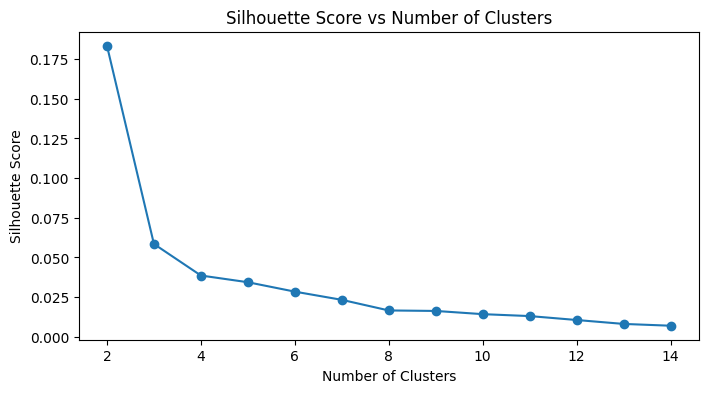


Best number of clusters: 2


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Combine labeled and unlabeled PCA data for clustering (unsupervised on ALL data)
X_all_pca = np.vstack([X_labeled_pca, X_unlabeled_pca])
print(f"Total samples for clustering: {X_all_pca.shape[0]}")

# Find optimal number of clusters using silhouette score
cluster_range = range(2, 15)
silhouette_scores = []

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_all_pca)
    score = silhouette_score(X_all_pca, labels_temp)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

# Choose best k
best_k = list(cluster_range)[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters: {best_k}")

In [8]:
# Fit KMeans with optimal k
n_clusters = best_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
all_cluster_labels = kmeans.fit_predict(X_all_pca)

# Split cluster labels back to labeled and unlabeled
cluster_labels_labeled = all_cluster_labels[: len(X_labeled_pca)]
cluster_labels_unlabeled = all_cluster_labels[len(X_labeled_pca) :]

print(f"Cluster distribution:")
for i in range(n_clusters):
    count = np.sum(all_cluster_labels == i)
    print(f"  Cluster {i}: {count} samples ({count/len(all_cluster_labels)*100:.1f}%)")

# Final silhouette score
final_silhouette = silhouette_score(X_all_pca, all_cluster_labels)
print(f"\nFinal Silhouette Score with k={n_clusters}: {final_silhouette:.4f}")

Cluster distribution:
  Cluster 0: 8541 samples (25.0%)
  Cluster 1: 25622 samples (75.0%)

Final Silhouette Score with k=2: 0.1834

Final Silhouette Score with k=2: 0.1834


In [9]:
# Add cluster labels as additional features (one-hot encoded for better NN performance)
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
cluster_onehot_labeled = encoder.fit_transform(cluster_labels_labeled.reshape(-1, 1))
cluster_onehot_unlabeled = encoder.transform(cluster_labels_unlabeled.reshape(-1, 1))

# Combine PCA features with cluster one-hot encoding
X_labeled_final = np.hstack([X_labeled_pca, cluster_onehot_labeled])
X_unlabeled_final = np.hstack([X_unlabeled_pca, cluster_onehot_unlabeled])

print(f"Final labeled features shape: {X_labeled_final.shape}")
print(f"Final unlabeled features shape: {X_unlabeled_final.shape}")
print(f"Features: {n_components} PCA components + {n_clusters} cluster indicators")

Final labeled features shape: (5096, 62)
Final unlabeled features shape: (29067, 62)
Features: 60 PCA components + 2 cluster indicators


## 3. Split Labeled Data into Train/Validation/Test


In [10]:
# Split: 60% train, 20% validation, 20% test
# Using X_labeled_final which includes PCA + cluster features
X_train, X_temp, y_train, y_temp = train_test_split(
    X_labeled_final, y_labeled, test_size=0.4, random_state=42, stratify=y_labeled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features per sample: {X_train.shape[1]}")

Training set: 3057 samples
Validation set: 1019 samples
Test set: 1020 samples
Features per sample: 62


In [11]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader for mini-batch training
batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Number of batches per epoch: {len(train_loader)}")

Number of batches per epoch: 48


## 4. Define and Train Neural Network


In [12]:
# Define the neural network
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.3):
        super(NeuralNetClassifier, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 2))  # 2 classes
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Input dimension = PCA components + cluster one-hot features
input_dim = n_components + n_clusters
print(f"Neural network input dimension: {input_dim}")

# Initialize model
model = NeuralNetClassifier(input_dim=input_dim, hidden_dims=[64, 32], dropout=0.3).to(
    device
)
print(model)

Neural network input dimension: 62
NeuralNetClassifier(
  (network): Sequential(
    (0): Linear(in_features=62, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [13]:
# Training setup
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Helper function to compute accuracy
def compute_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean().item()
    return acc

In [14]:
# Training loop with early stopping
epochs = 1000
patience = 500
best_val_acc = 0.0
best_weights = None
epochs_without_improvement = 0

train_losses = []
val_accs = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation accuracy
    val_acc = compute_accuracy(model, X_val_t, y_val_t)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = {k: v.clone() for k, v in model.state_dict().items()}
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f} - Best Val Acc: {best_val_acc:.4f}"
        )

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

Epoch 20/1000 - Loss: 0.3823 - Val Acc: 0.7468 - Best Val Acc: 0.7694
Epoch 40/1000 - Loss: 0.3180 - Val Acc: 0.7704 - Best Val Acc: 0.7704
Epoch 40/1000 - Loss: 0.3180 - Val Acc: 0.7704 - Best Val Acc: 0.7704
Epoch 60/1000 - Loss: 0.2567 - Val Acc: 0.7674 - Best Val Acc: 0.7704
Epoch 60/1000 - Loss: 0.2567 - Val Acc: 0.7674 - Best Val Acc: 0.7704
Epoch 80/1000 - Loss: 0.2339 - Val Acc: 0.7498 - Best Val Acc: 0.7704
Epoch 80/1000 - Loss: 0.2339 - Val Acc: 0.7498 - Best Val Acc: 0.7704
Epoch 100/1000 - Loss: 0.2117 - Val Acc: 0.7380 - Best Val Acc: 0.7704
Epoch 100/1000 - Loss: 0.2117 - Val Acc: 0.7380 - Best Val Acc: 0.7704
Epoch 120/1000 - Loss: 0.1898 - Val Acc: 0.7419 - Best Val Acc: 0.7704
Epoch 120/1000 - Loss: 0.1898 - Val Acc: 0.7419 - Best Val Acc: 0.7704
Epoch 140/1000 - Loss: 0.1880 - Val Acc: 0.7458 - Best Val Acc: 0.7704
Epoch 140/1000 - Loss: 0.1880 - Val Acc: 0.7458 - Best Val Acc: 0.7704
Epoch 160/1000 - Loss: 0.1655 - Val Acc: 0.7458 - Best Val Acc: 0.7704
Epoch 160/100

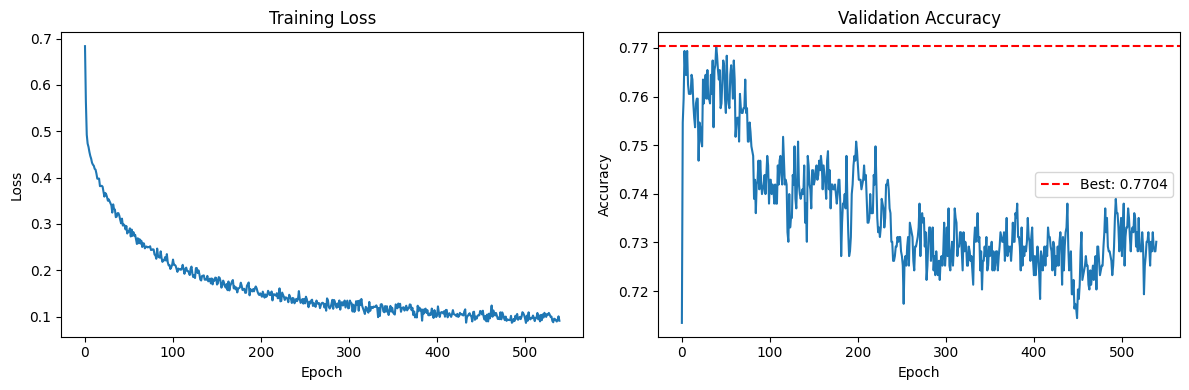

In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")

axes[1].plot(val_accs)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].axhline(
    y=best_val_acc, color="r", linestyle="--", label=f"Best: {best_val_acc:.4f}"
)
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Evaluate on Test Set


In [16]:
# Load best weights
model.load_state_dict(best_weights)

# Test accuracy
test_acc = compute_accuracy(model, X_test_t, y_test_t)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Test Accuracy: 0.7412 (74.12%)


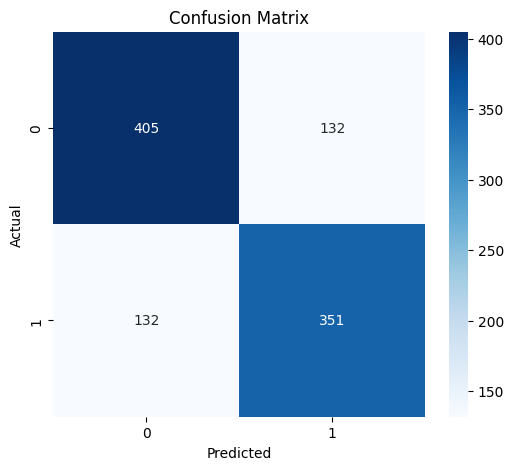


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       537
           1       0.73      0.73      0.73       483

    accuracy                           0.74      1020
   macro avg       0.74      0.74      0.74      1020
weighted avg       0.74      0.74      0.74      1020



In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    test_preds = torch.argmax(logits, dim=1).cpu().numpy()

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, test_preds))

## 6. Predict on Unlabeled Data and Create Submission


In [18]:
# Convert unlabeled data to tensor (using X_unlabeled_final with cluster features)
X_unlabeled_t = torch.tensor(X_unlabeled_final, dtype=torch.float32).to(device)

# Make predictions
model.eval()
with torch.no_grad():
    logits = model(X_unlabeled_t)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

print(f"Predictions shape: {predictions.shape}")
print(f"Prediction distribution: {np.bincount(predictions)}")
print(f"Percentage predicted as 1: {predictions.mean()*100:.2f}%")

Predictions shape: (29067,)
Prediction distribution: [15639 13428]
Percentage predicted as 1: 46.20%


In [19]:
# Create submission dataframe
submission = pd.DataFrame({"ID": unlabeled_ids, "prediction": predictions})

submission.head()

,ID,prediction
0,20160303022202,1
1,20160303052049,0
2,20160303052319,0
3,20160303055318,1
4,20160303063505,1


In [20]:
# Save submission
submission.to_csv("submit_nn.csv", index=False)
print(f"Submission saved to submit_nn.csv with {len(submission)} predictions")

Submission saved to submit_nn.csv with 29067 predictions
